# Code Summary

# This notebook adheres to TRIPOD Criteria

# Preprocess Data 
    # select data (A_ variables or non-A_ variables)
    # select the label (y) and remove it from the dataset (X)
    # exclude future variables
    # exclude variables more than 50% blank
    # train/test split (80:20)
    # make a dictionary of which variables are continuous vs ordinal vs categorical
    # normalize training continuous variables to be mean centered on 0, std_dev = 1
    # keep ordinal variables as is (but map unknown or NaN to 99 or -1 or 0)
    # one-hot encoding of categorical variables
    # apply the same training normalization to test data
# Visualize data
    # Plot some initial data distributions
    # Plot covariance matrix heatmap showing which variables correlate most with outcome variables
# Train/Validate
    # Select 5 algorithms which can take normalized continuous variables and one-hot encoded categorical variables and output a probability
    # 1. XGBoost (Extreme Gradient Boosting), 2. LightGBM, 3. CatBoost, 4. Neural Networks, 5. Gradient Boosting Classifier (e.g., scikit-learn's GradientBoostingClassifier)
    # Bootstrapped nested k-fold cross-validation (100-fold bootstrap, k=5, score should be the ROC-AUC score)
    # For the nested part, select a random range of hyperparameters appropriate for each of the 5 algorithms, with 20 different hyperparameter combinations total per algorithm
    # Plot progress bars showing training progress
    # Plot one bar plot per algorithm of performance vs training param combination (thus the x-axis should have 20 ticks)
    # Print out the best hyperparameter combinations for each algorithm
    # Use stacking to get a single aggregate score based on all the 5 models with the best hyperparameter scores
    # Display Results
        # Plot ROC-AUC plot showing the best bootstrapped nested k-fold cross-validation (ROC-AUC) score of each of the 5 algorithms + the 1 stacking algorithm score
        # Plot bar plot showing the best bootstrapped nested k-fold cross-validation (ROC-AUC) score of each of the 5 algorithms + the 1 stacking algorithm score with error bars giving the 95% CI from bootstrapping
        # Convert label probability into binary label (>=0.5 = 1, <0.5 = 0)
        # Use binary labels to get accuracy, sensitivity, specificity, F1-score, and plot confusion matrix
    # Retrain the 5 models (with best hyperparams) and stacked model on the full train dataset (with progress bar)
    # Save the final trained 5 models and stacked model
# Test
    # Use the stacked model and all 5 final trained models to predict the label in the held-out test set
    # Use 100-fold bootstrapping of test set to get 95% CI
    # Display Results
        # Plot ROC-AUC plot showing the best bootstrapped nested k-fold cross-validation (ROC-AUC) score of each of the 5 algorithms + the 1 stacking algorithm score
        # Plot bar plot showing the best bootstrapped nested k-fold cross-validation (ROC-AUC) score of each of the 5 algorithms + the 1 stacking algorithm score with error bars giving the 95% CI from bootstrapping
        # Convert label probability into binary label (>=0.5 = 1, <0.5 = 0)
        # Use binary labels to get accuracy, sensitivity, specificity, F1-score, and plot confusion matrix
     

In [1]:
# NOTE I SET SMOTE to 0.5 FROM 0.2

In [2]:
import wandb

# initialize project
# define config params (dict)
# log results (numbers, etc.)
# log images

In [3]:
from ent_utils import *

'''
Toggle experiment settings here
'''

# Record the start time
start_time = datetime.datetime.now()

experiment_name = "30d_mort_demo"  # Set your experiment name, if any
clear_cache = True # Set to True to clear cached processed data and models and re-run everything from scratch

use_mini_dataset = False
# use_mini_dataset = True # Set to True for testing with a mini-train and test dataset (first 500 entries of each)

dataset_option = "use_full_ncbd_dataset"
# dataset_option = "use_selected_A_dataset" # Use selected A variables only

# outcome_option = "use_30_day_readmission"; class_labels = ['No Readmission','Readmission within 30 Days']; outcome_name = 'READM_HOSP_30_DAYS'
outcome_option = "use_30_day_mortality"; class_labels = ['Living','Deceased within 30 Days']; outcome_name = 'PUF_30_DAY_MORT_CD'
# outcome_option = "use_90_day_mortality"; class_labels = ['Living','Deceased within 90 Days']; outcome_name = 'PUF_90_DAY_MORT_CD'

split_by_dx_date=False
# split_by_dx_date=True # Set to True for sensitivity analysis for spliting by diagnosis date: train (early cases) vs test (late cases)

exclude_variables_more_than_x_proportion_blank = 0.5

train_test_split = [80,20]

use_feature_reduction = True
use_lasso = True; use_rfe = False; use_rf = False; use_boruta = False; overlap_mode="all_overlap"

# use_PCA = True
use_PCA = False

n_bootstraps_for_training = 10
n_bootstraps_for_results = 100
num_k_fold_splits = 5

if use_mini_dataset:
    n_bootstraps_for_training = 2
    n_bootstraps_for_results = 5
    num_k_fold_splits = 2

In [4]:
# Load the database .sav file
df, meta = pyreadstat.read_sav("data/Aman_NCDB_ML_ONM_HNSCC_Database.sav")


In [5]:
import glob

if clear_cache:
    # Clear cached processed data and models dynamically
    data_files = glob.glob(f"data/{experiment_name}*")
    model_files = glob.glob(f"models/{experiment_name}*")
    cache_files = data_files + model_files
    
    for file in cache_files:
        if os.path.exists(file):
            os.remove(file)
            print(f"Removed cached file: {file}")
        else:
            print(f"No cached file found to remove: {file}")

Removed cached file: data/30d_mort_demo_test_data.sav
Removed cached file: data/30d_mort_demo_train_data.sav


In [6]:
# '''
# Show data distribution and basic statistics
# '''

# visualize_demographics(df)

# # Print out all the column names of the DataFrame
# print(df.columns.tolist())

# # Generate data summaries
# demographic_summaries, age_stats, ln_stats = summarize_demographics(df)

# print("Age Statistics:")
# display(age_stats)

# print("Lymph Node Statistics:")
# display(ln_stats)

# print("\nDemographic Summaries:")
# for key, value in demographic_summaries.items():
#     print(f"\n{key}:")
#     display(value)


In [7]:
# Preprocess Data 
    # select data (A_ variables or non-A_ variables)
    # select the label (y) and remove it from the dataset (X)
    # exclude future variables
    # exclude variables more than 50% blank
    # train/test split (80:20)
    # make a dictionary of which variables are continuous vs ordinal vs categorical
    # normalize training continuous variables to be mean centered on 0, std_dev = 1
    # keep ordinal variables as is (but map unknown or NaN to 99 or -1 or 0)
    # one-hot encoding of categorical variables
    # apply the same training normalization to test data
    
X, y = filter_variables(df,
                       dataset_option,
                       outcome_option, 
                       exclude_variables_more_than_x_proportion_blank, 
                       verbose=True, 
                       plot_histogram=False)

print('Final columns')
print(X.columns.tolist())

Using full NCBD dataset
Removing "A_" variables
Outcome is 30 d mortality
Number of entries excluded due to missing outcomes: 4884
Removing treatment-related variables
Excluded variables and their proportion of blanks:
CS_METS_DX_BONE: 51.38%
CS_METS_DX_BRAIN: 51.38%
CS_METS_DX_LIVER: 51.38%
CS_METS_DX_LUNG: 51.38%
MED_INC_QUAR_2020: 100.00%
METS_AT_DX_BONE: 66.55%
METS_AT_DX_BRAIN: 66.55%
METS_AT_DX_DISTANT_LN: 66.55%
METS_AT_DX_LIVER: 66.55%
METS_AT_DX_LUNG: 66.55%
METS_AT_DX_OTHER: 66.55%
NO_HSD_QUAR_2020: 100.00%
SCHEMA_DISC_1: 100.00%
SCHEMA_DISC_2: 98.76%
SCHEMA_DISC_3: 100.00%
SLN_EXAM: 100.00%
SLN_POS: 100.00%
      ADENOID_CYSTIC_BSLD ADENOPATHY AFP_POST_ORCH_RANGE AFP_POST_ORCH_VALUE  \
4                                                                              
5                                                                              
6                                                                              
7                                                     

In [8]:
# Train:test split:
    # split using train_test_split variable = [70:30]
X_train_raw, y_train_raw, X_test_raw, y_test_raw = custom_train_test_split(X,y,train_test_split,split_by_dx_date=split_by_dx_date)

# Merging X and y datasets for both train and test and saving train/test data as .sav files
train_data = pd.merge(X_train_raw, y_train_raw, left_index=True, right_index=True); test_data = pd.merge(X_test_raw, y_test_raw, left_index=True, right_index=True)
# Save train and test data as SPSS .sav file
pyreadstat.write_sav(train_data, f'data/{experiment_name}_train_data.sav'); pyreadstat.write_sav(test_data, f'data/{experiment_name}_test_data.sav')

# Data normalization:
    # make a dictionary of which variables are continuous vs ordinal vs categorical
        # normalize training continuous variables to be mean centered on 0, std_dev = 1
        # keep ordinal variables as is (but map unknown or NaN to 99 or -1 or 0)
        # one-hot encoding of categorical variables
    # apply the same training normalization to test data

X_train, X_test = normalize(X_train_raw, X_test_raw)

# Outcome binarization:
    # Values of 0 will stay as 0
    # Values >= 1 will become 1

y_train, y_test = binarize(y_train_raw, y_test_raw)


In [9]:
# import pandas as pd
# import numpy as np
# from scipy.stats import chi2_contingency, pearsonr

# # Function to calculate category counts and percentages
# def calculate_counts_and_percents(data, feature):
#     counts = data[feature].value_counts(dropna=False)
#     percents = data[feature].value_counts(normalize=True, dropna=False) * 100
#     return counts, percents

# # Prepare the demographics table
# features = sorted(X_train_raw.columns)
# rows_list = []

# for feature in features:
#     train_counts, train_percents = calculate_counts_and_percents(X_train_raw, feature)
#     test_counts, test_percents = calculate_counts_and_percents(X_test_raw, feature)
    
#     # Only include categories with sufficient data in both training and testing datasets
#     common_categories = train_counts.index.intersection(test_counts.index)
    
#     for category in common_categories:
#         if train_counts[category] > 1 and test_counts[category] > 1:  # Ensure at least two data points
#             # Calculating chi-squared test
#             contingency_table = pd.crosstab(X_train_raw[feature] == category, X_test_raw[feature] == category)
#             chi2, p_val, _, _ = chi2_contingency(contingency_table) if not contingency_table.empty else (np.nan, np.nan, np.nan, np.nan)
            
#             # Calculating correlations safely
#             train_correlated = X_train_raw[feature][X_train_raw[feature] == category]
#             test_correlated = X_test_raw[feature][X_test_raw[feature] == category]
#             if len(train_correlated) > 1 and len(test_correlated) > 1:
#                 train_corr = pearsonr(train_correlated, y_train_raw[X_train_raw[feature] == category])[0]
#                 test_corr = pearsonr(test_correlated, y_test_raw[X_test_raw[feature] == category])[0]
#             else:
#                 train_corr, test_corr = np.nan, np.nan
            
#             row = {
#                 'Feature': feature,
#                 'Category': category,
#                 'Train Count': train_counts[category],
#                 'Train Percent': train_percents[category],
#                 'Test Count': test_counts[category],
#                 'Test Percent': test_percents[category],
#                 'P-Value': p_val,
#                 'Train Correlation': train_corr,
#                 'Test Correlation': test_corr
#             }
#             rows_list.append(row)

#     # Add missing value row if there are any
#     if pd.isnull(train_counts.get(np.nan, 0)) or pd.isnull(test_counts.get(np.nan, 0)):
#         row_missing = {
#             'Feature': feature,
#             'Category': 'Missing',
#             'Train Count': X_train_raw[feature].isna().sum(),
#             'Train Percent': X_train_raw[feature].isna().mean() * 100,
#             'Test Count': X_test_raw[feature].isna().sum(),
#             'Test Percent': X_test_raw[feature].isna().mean() * 100,
#             'P-Value': np.nan,
#             'Train Correlation': np.nan,
#             'Test Correlation': np.nan
#         }
#         rows_list.append(row_missing)

# demographics_table = pd.DataFrame(rows_list)

# # Set more appealing formatting for percentages, etc.
# demographics_table['Train Percent'] = demographics_table['Train Percent'].map('{:.2f}%'.format)
# demographics_table['Test Percent'] = demographics_table['Test Percent'].map('{:.2f}%'.format)

# # Save to Excel
# demographics_table.to_excel(f"{experiment_name}_demographics_table.xlsx", index=False)


In [10]:
# Calculate the proportions
train_positives_percentage = (np.sum(y_train) / len(y_train)) * 100; train_negatives_percentage = 100 - train_positives_percentage
test_positives_percentage = (np.sum(y_test) / len(y_test)) * 100; test_negatives_percentage = 100 - test_positives_percentage

# Format and print the proportions
print(f"Train data: {train_positives_percentage:.2f}%:{train_negatives_percentage:.2f}% positive:negative cases")
print(f"Test data: {test_positives_percentage:.2f}%:{test_negatives_percentage:.2f}% positive:negative cases")


Train data: 0.87%:99.13% positive:negative cases
Test data: 0.87%:99.13% positive:negative cases


In [11]:
# TODO: FIX THE FEATURE REDUCTION CODE so that it removes entire features, not just categories within features

In [12]:
if use_feature_reduction:
    # Reduce the number of features using various feature reduction methods
    X_train, X_test = feature_reduction(use_lasso,use_rfe,use_rf,use_boruta,X_train,X_test,y_train,y_test,overlap_mode="all_overlap")     
else:
    X_train, X_test = X_train, X_test


There are 1600 features in the training data.
Auto-detected 1023 variable groups.

Selected 50 groups (target 50).


In [13]:
print(X_train.columns.tolist())

['AGE', 'CROWFLY', 'YEAR_OF_DIAGNOSIS', 'REGIONAL_NODES_POSITIVE', 'TUMOR_SIZE_SUMMARY_16', 'TUMOR_SIZE', 'DX_SURG_STARTED_DAYS', 'DX_DEFSURG_STARTED_DAYS', 'SURG_DISCHARGE_DAYS', 'REGIONAL_NODES_EXAMINED', 'NO_HSD_QUAR_00', 'NO_HSD_QUAR_12', 'NO_HSD_QUAR_2016', 'MED_INC_QUAR_00', 'MED_INC_QUAR_12', 'MED_INC_QUAR_2016', 'UR_CD_03', 'UR_CD_13', 'CDCC_TOTAL_BEST', 'BEHAVIOR', 'RACE_1.0', 'RACE_10.0', 'RACE_11.0', 'RACE_12.0', 'RACE_13.0', 'RACE_14.0', 'RACE_15.0', 'RACE_16.0', 'RACE_17.0', 'RACE_2.0', 'RACE_20.0', 'RACE_21.0', 'RACE_22.0', 'RACE_25.0', 'RACE_27.0', 'RACE_3.0', 'RACE_30.0', 'RACE_4.0', 'RACE_5.0', 'RACE_6.0', 'RACE_7.0', 'RACE_8.0', 'RACE_96.0', 'RACE_97.0', 'RACE_98.0', 'RACE_99.0', 'SEX_1.0', 'SEX_2.0', 'FACILITY_TYPE_CD_1.0', 'FACILITY_TYPE_CD_2.0', 'FACILITY_TYPE_CD_3.0', 'FACILITY_TYPE_CD_4.0', 'FACILITY_TYPE_CD_nan', 'FACILITY_LOCATION_CD_1.0', 'TNM_CLIN_STAGE_GROUP_', 'TNM_CLIN_STAGE_GROUP_   0', 'TNM_CLIN_STAGE_GROUP_   1', 'TNM_CLIN_STAGE_GROUP_   2', 'TNM_CLIN_S

In [14]:

['AGE', 'CROWFLY', 'YEAR_OF_DIAGNOSIS', 'REGIONAL_NODES_POSITIVE', 'TUMOR_SIZE_SUMMARY_16', 'TUMOR_SIZE', 'DX_SURG_STARTED_DAYS', 'DX_DEFSURG_STARTED_DAYS', 'SURG_DISCHARGE_DAYS', 'REGIONAL_NODES_EXAMINED', 'NO_HSD_QUAR_00', 'NO_HSD_QUAR_12', 'NO_HSD_QUAR_2016', 'MED_INC_QUAR_00', 'MED_INC_QUAR_12', 'MED_INC_QUAR_2016', 'UR_CD_03', 'UR_CD_13', 'CDCC_TOTAL_BEST', 'BEHAVIOR', 'RACE_1.0', 'RACE_10.0', 'RACE_11.0', 'RACE_12.0', 'RACE_13.0', 'RACE_14.0', 'RACE_15.0', 'RACE_16.0', 'RACE_17.0', 'RACE_2.0', 'RACE_20.0', 'RACE_21.0', 'RACE_22.0', 'RACE_25.0', 'RACE_27.0', 'RACE_3.0', 'RACE_30.0', 'RACE_4.0', 'RACE_5.0', 'RACE_6.0', 'RACE_7.0', 'RACE_8.0', 'RACE_96.0', 'RACE_97.0', 'RACE_98.0', 'RACE_99.0', 'SEX_1.0', 'SEX_2.0', 'FACILITY_TYPE_CD_1.0', 'FACILITY_TYPE_CD_2.0', 'FACILITY_TYPE_CD_3.0', 'FACILITY_TYPE_CD_4.0', 'FACILITY_TYPE_CD_nan', 'FACILITY_LOCATION_CD_1.0', 'TNM_CLIN_STAGE_GROUP_', 'TNM_CLIN_STAGE_GROUP_   0', 'TNM_CLIN_STAGE_GROUP_   1', 'TNM_CLIN_STAGE_GROUP_   2', 'TNM_CLIN_STAGE_GROUP_   3', 'TNM_CLIN_STAGE_GROUP_   4', 'TNM_CLIN_STAGE_GROUP_  4A', 'TNM_CLIN_STAGE_GROUP_  4B', 'TNM_CLIN_STAGE_GROUP_  4C', 'TNM_CLIN_STAGE_GROUP_  99']
selected_features = ['AGE', # allow user to enter "Age" 
                    'CROWFLY', # allow user to enter "Patient's residence distance from nearest hospital in miles (estimate is okay)" 
                    'YEAR_OF_DIAGNOSIS', # allow user to enter "Year of Diagnosis of HNSCC"
                    'REGIONAL_NODES_POSITIVE', # allow user to enter "Number of positive regional nodes" 
                    'TUMOR_SIZE_SUMMARY_16', # allow user to enter "Tumor Size (size of largest dimension in mm), and use that value for both this and the below TUMOR_SIZE variable" 
                    'TUMOR_SIZE', # allow user to enter "Tumor Size (size of largest dimension in mm), and use that value for both this and the above TUMOR_SIZE_SUMMARY_16 variable" 
                    'DX_SURG_STARTED_DAYS', # allow user to enter "Number of days from diagnosis to first surgical procedure" 
                    'DX_DEFSURG_STARTED_DAYS', # allow user to enter "Number of days from diagnosis to definitive surgical resection of primary site" 
                    'SURG_DISCHARGE_DAYS', # allow user to enter "Number of days from surgery to discharge" 
                    'REGIONAL_NODES_EXAMINED', # allow user to enter "Number of regional nodes examined" 
                    'NO_HSD_QUAR_00', 
                    'NO_HSD_QUAR_12', 
                    'NO_HSD_QUAR_2016', 
                    'MED_INC_QUAR_00', 
                    'MED_INC_QUAR_12', 
                    'MED_INC_QUAR_2016', 
                    'UR_CD_03', 
                    'UR_CD_13', 
                    'CDCC_TOTAL_BEST', # allow user to select from a dropdown list "Charlson/Deyo comorbidity score", see note below
                    'BEHAVIOR', 
                    'RACE_1.0', 'RACE_10.0', 'RACE_11.0', 'RACE_12.0', 'RACE_13.0', 'RACE_14.0', 'RACE_15.0', 'RACE_16.0', 'RACE_17.0', 'RACE_2.0', 'RACE_20.0', 'RACE_21.0', 'RACE_22.0', 'RACE_25.0', 'RACE_27.0', 'RACE_3.0', 'RACE_30.0', 'RACE_4.0', 'RACE_5.0', 'RACE_6.0', 'RACE_7.0', 'RACE_8.0', 'RACE_96.0', 'RACE_97.0', 'RACE_98.0', 'RACE_99.0', 
                    'SEX_1.0', 'SEX_2.0', 
                    'FACILITY_TYPE_CD_1.0', 'FACILITY_TYPE_CD_2.0', 'FACILITY_TYPE_CD_3.0', 'FACILITY_TYPE_CD_4.0', 'FACILITY_TYPE_CD_nan', 
                    'TNM_CLIN_STAGE_GROUP_', 'TNM_CLIN_STAGE_GROUP_   0', 'TNM_CLIN_STAGE_GROUP_   1', 'TNM_CLIN_STAGE_GROUP_   2', 'TNM_CLIN_STAGE_GROUP_   3', 'TNM_CLIN_STAGE_GROUP_   4', 'TNM_CLIN_STAGE_GROUP_  4A', 'TNM_CLIN_STAGE_GROUP_  4B', 'TNM_CLIN_STAGE_GROUP_  4C', 'TNM_CLIN_STAGE_GROUP_  99']

# final_features = ['AGE', 
#  'CROWFLY', 
#  'YEAR_OF_DIAGNOSIS', 
#  'REGIONAL_NODES_POSITIVE', 
#  'TUMOR_SIZE_SUMMARY_16', 
#  'TUMOR_SIZE', 
#  'DX_SURG_STARTED_DAYS', 
#  'DX_DEFSURG_STARTED_DAYS', 
#  'SURG_DISCHARGE_DAYS', 
#  'REGIONAL_NODES_EXAMINED', 
#  'NO_HSD_QUAR_00', 
#  'NO_HSD_QUAR_12', 
#  'NO_HSD_QUAR_2016', 
#  'MED_INC_QUAR_00', 
#  'MED_INC_QUAR_12', 
#  'MED_INC_QUAR_2016', 
#  'UR_CD_03', 
#  'UR_CD_13', 
#  'CDCC_TOTAL_BEST', 
#  'BEHAVIOR', 
#  'RACE_1.0', 'RACE_10.0', 'RACE_11.0', 'RACE_12.0', 'RACE_13.0', 'RACE_14.0', 'RACE_15.0', 'RACE_16.0', 'RACE_17.0', 'RACE_2.0', 'RACE_20.0', 'RACE_21.0', 'RACE_22.0', 'RACE_25.0', 'RACE_27.0', 'RACE_28.0', 'RACE_3.0', 'RACE_30.0', 'RACE_4.0', 'RACE_5.0', 'RACE_6.0', 'RACE_7.0', 'RACE_8.0', 'RACE_96.0', 'RACE_97.0', 'RACE_98.0', 'RACE_99.0', 
#  'SEX_1.0', 'SEX_2.0', 
#  'FACILITY_TYPE_CD_1.0', 'FACILITY_TYPE_CD_2.0', 'FACILITY_TYPE_CD_3.0', 'FACILITY_TYPE_CD_4.0', 'FACILITY_TYPE_CD_nan', 
#  'FACILITY_LOCATION_CD_1.0', 'FACILITY_LOCATION_CD_2.0',
#  'CLIN_STAGE']


# final_features = [
#     'AGE', # keep this, allow user to enter "Age" 
#     'CROWFLY', # keep this, allow user to enter "Patient's residence distance from nearest hospital in miles (estimate is okay)" 
#     'REGIONAL_NODES_POSITIVE', # keep this, allow user to enter "Number of positive regional nodes" 
#     'TUMOR_SIZE_SUMMARY_16', # remove this... it's just one-hot encoding of tumor size 
#     'TUMOR_SIZE', # keep this, allow user to enter "Tumor Size (size of largest dimension in mm)" 
#     'DX_SURG_STARTED_DAYS', # keep this, allow user to enter "Number of days from diagnosis to first surgical procedure" 
#     'DX_DEFSURG_STARTED_DAYS', # keep this, allow user to enter "Number of days from diagnosis to definitive surgical resection of primary site" 
#     'SURG_DISCHARGE_DAYS', # keep this, allow user to enter "Number of days from surgery to discharge" 
#     'REGIONAL_NODES_EXAMINED', # keep this, allow user to enter "Number of regional nodes examined" 
#     # 'NO_HSD_QUAR_00', # remove this... it's the percentage of people in the census tract with no high school diploma in 2000 
#     # 'NO_HSD_QUAR_2016', # remove this... it's the percentage of people in the census tract with no high school diploma in 2016 
#     # 'UR_CD_03', # remove this... it's the urban-rural classification of the census tract 
#     'CDCC_TOTAL_BEST', # keep this, allow user to select from a dropdown list "Charlson/Deyo comorbidity score", see note below 
#     'SEX_1.0', # keep this, allow user to select from M or F or other, M means SEX_1.0 is positive, F means negative, other means leave it blank 
#     # 'FACILITY_TYPE_CD_nan', # remove this... it's just one-hot encoding of facility type left blank 
#     'FACILITY_LOCATION_CD_2.0', # keep this, user should select state from a dropdown, see note on facility location below 'FACILITY_LOCATION_CD_5.0', # see note on facility location below 
#     'FACILITY_LOCATION_CD_nan', # see note on facility location below 
#     'PUF_MULT_SOURCE_0', # keep this, allow user to select from two options "Was the patient treated at multiple CoC-accredited (Commission of Cancer) facilities", see note below 
#     # 'PUF_MULT_SOURCE_1', # keep this, same as above, if user selects "Yes", this will be 1, if "No", this will be 0 
#     'INSURANCE_STATUS_1.0', # keep this, user should select patient insurance from a dropdown, see note below 
#     'INSURANCE_STATUS_3.0', # see note below 
#     # 'PUF_MEDICAID_EXPN_CODE_9.0', # remove this 
#     'SEQUENCE_NUMBER_1.0', # keep this, allow user to enter "How many primary cancers has the patient had before this current HNSCC primary" and use the answer to map to a code, see note below 
#     'SEQUENCE_NUMBER_2.0', # same as above 
#     # 'CLASS_OF_CASE_10', # remove this... it's just one-hot encoding of class of case, indicating whether or not to treat at this facility 
#     # 'CLASS_OF_CASE_13', # remove this... it's just one-hot encoding of class of case 
#     # 'CLASS_OF_CASE_14', # remove this... it's just one-hot encoding of class of case 
#     # 'CLASS_OF_CASE_21', # remove this... it's just one-hot encoding of class of case 
#     # 'CLASS_OF_CASE_22', # remove this... it's just one-hot encoding of class of case 
#     # 'PRIMARY_SITE_C019', # remove this... it's just one-hot encoding of primary site 
#     # 'PRIMARY_SITE_C079', # remove this... it's just one-hot encoding of primary site 
#     'GRADE_3.0', # keep this, allow user to select from a dropdown list "Tumor Grade", see note below 
#     'TNM_CLIN_T_   c1', # keep this, allow user to select from a dropdown list "Clinical T stage", see note below 
#     'TNM_CLIN_STAGE_GROUP_   1', # keep this, allow user to select from a dropdown list "Clinical Stage Group", see note below 
#     'TNM_CLIN_STAGE_GROUP_  4A', # same as above 
#     'TNM_PATH_T_   p1', # keep this, allow user to select from a dropdown list "Pathological T stage", see note below 
#     'TNM_PATH_T_   p2', # same as above 
#     'TNM_PATH_T_  p4A', # same as above 
#     'TNM_PATH_N_   p0', # keep this, allow user to select from a dropdown list "Pathological N stage", see note below 
#     'TNM_PATH_M_   pX', # keep this, allow user to select from a dropdown list "Pathological M stage", see note below 
#     'ANALYTIC_STAGE_GROUP_1', # keep this, allow user to select from a dropdown list "Overall AJCC Stage Group", see note below 
#     # 'CS_EXTENSION_100.0', # remove this... it's just one-hot encoding of CS extension which is a deprecated variable 
#     # 'CS_EXTENSION_300.0', # remove this... it's just one-hot encoding of CS extension which is a deprecated variable 
#     # 'CS_EXTENSION_535.0', # remove this... it's just one-hot encoding of CS extension which is a deprecated variable 
#     # 'RX_HOSP_SURG_PRIM_SITE_0.0', # remove this... it's just one-hot encoding of the primary surgical procedure 
#     # 'RX_HOSP_SURG_PRIM_SITE_42.0', # remove this... it's just one-hot encoding of the primary surgical procedure 
#     'RX_HOSP_SURG_APPR_2010_1.0', # keep this, allow user to select from a dropdown list "Surgical approach for primary site", see note below 
#     'RX_HOSP_SURG_APPR_2010_5.0', # same as above 
#     # 'LN_SIZE_0.0', # remove this... it's just one-hot encoding of a deprecated variable 
#     # 'CS_SITESPECIFIC_FACTOR_4_0.0', # remove this... it's just one-hot encoding of a deprecated variable 
#     # 'HISTOLOGY_8071.0', # remove this... it's just one-hot encoding of histology 
#     # 'CS_SITESPECIFIC_FACTOR_9_10.0', # remove this... it's just one-hot encoding of a deprecated variable 
#     # 'CS_SITESPECIFIC_FACTOR_9_988.0', # remove this... it's just one-hot encoding of a deprecated variable 
#     # 'CS_SITESPECIFIC_FACTOR_11_999', # remove this... it's just one-hot encoding of a deprecated variable 
#     # 'CS_SITESPECIFIC_FACTOR_10_988.0', # remove this... it's just one-hot encoding of a deprecated variable 
#     # 'CS_SITESPECIFIC_FACTOR_10_998.0'# remove this... it's just one-hot encoding of a deprecated variable 
#     ] 

print('Manually curating final selected features for clinical reproducibility:')
X_train = X_train[selected_features]
X_test = X_test[selected_features]

def collapse_minor_races(X_train, X_test, threshold=0.01):
    # Identify race columns
    race_cols = [c for c in X_train.columns if c.startswith("RACE_")]
    
    # Compute frequencies in training set
    freqs = X_train[race_cols].mean(axis=0)  # since one-hot, mean = proportion
    
    # Select rare categories
    rare_cols = freqs[freqs < threshold].index.tolist()
    print(f"Aggregating {len(rare_cols)} rare race categories into RACE_OTHER")
    
    # Create RACE_OTHER column in train/test
    X_train["RACE_OTHER"] = X_train[rare_cols].max(axis=1)
    X_test["RACE_OTHER"]  = X_test[rare_cols].max(axis=1)
    
    # Drop original rare columns
    X_train = X_train.drop(columns=rare_cols)
    X_test  = X_test.drop(columns=rare_cols)
    
    return X_train, X_test

# Usage:
X_train, X_test = collapse_minor_races(X_train, X_test, threshold=0.01)

print('Final columns')
print(X_train.columns.tolist())
print(f'X_train and X_test now have {X_train.shape[1]} features each from the manual feature curation and selective aggregation.')

Manually curating final selected features for clinical reproducibility:
Aggregating 24 rare race categories into RACE_OTHER
Final columns
['AGE', 'CROWFLY', 'YEAR_OF_DIAGNOSIS', 'REGIONAL_NODES_POSITIVE', 'TUMOR_SIZE_SUMMARY_16', 'TUMOR_SIZE', 'DX_SURG_STARTED_DAYS', 'DX_DEFSURG_STARTED_DAYS', 'SURG_DISCHARGE_DAYS', 'REGIONAL_NODES_EXAMINED', 'NO_HSD_QUAR_00', 'NO_HSD_QUAR_12', 'NO_HSD_QUAR_2016', 'MED_INC_QUAR_00', 'MED_INC_QUAR_12', 'MED_INC_QUAR_2016', 'UR_CD_03', 'UR_CD_13', 'CDCC_TOTAL_BEST', 'BEHAVIOR', 'RACE_1.0', 'RACE_2.0', 'SEX_1.0', 'SEX_2.0', 'FACILITY_TYPE_CD_1.0', 'FACILITY_TYPE_CD_2.0', 'FACILITY_TYPE_CD_3.0', 'FACILITY_TYPE_CD_4.0', 'FACILITY_TYPE_CD_nan', 'TNM_CLIN_STAGE_GROUP_', 'TNM_CLIN_STAGE_GROUP_   0', 'TNM_CLIN_STAGE_GROUP_   1', 'TNM_CLIN_STAGE_GROUP_   2', 'TNM_CLIN_STAGE_GROUP_   3', 'TNM_CLIN_STAGE_GROUP_   4', 'TNM_CLIN_STAGE_GROUP_  4A', 'TNM_CLIN_STAGE_GROUP_  4B', 'TNM_CLIN_STAGE_GROUP_  4C', 'TNM_CLIN_STAGE_GROUP_  99', 'RACE_OTHER']
X_train and X_test 

In [15]:

final_features = ['AGE', # allow user to enter "Age" 
                    'CROWFLY', # allow user to enter "Patient's residence distance from nearest hospital in miles (estimate is okay)" 
                    'YEAR_OF_DIAGNOSIS', # allow user to enter "Year of Diagnosis of HNSCC"
                    'REGIONAL_NODES_POSITIVE', # allow user to enter "Number of positive regional nodes" 
                    'TUMOR_SIZE_SUMMARY_16', # allow user to enter "Tumor Size (size of largest dimension in mm), and use that value for both this and the below TUMOR_SIZE variable" 
                    'TUMOR_SIZE', # allow user to enter "Tumor Size (size of largest dimension in mm), and use that value for both this and the above TUMOR_SIZE_SUMMARY_16 variable" 
                    'DX_SURG_STARTED_DAYS', # allow user to enter "Number of days from diagnosis to first surgical procedure" 
                    'DX_DEFSURG_STARTED_DAYS', # allow user to enter "Number of days from diagnosis to definitive surgical resection of primary site" 
                    'SURG_DISCHARGE_DAYS', # allow user to enter "Number of days from surgery to discharge" 
                    'REGIONAL_NODES_EXAMINED', # allow user to enter "Number of regional nodes examined" 
                    'NO_HSD_QUAR_00', # allow user to enter "5 Digit ZIP code of patient's residence at time of diagnosis" and infer the HSD from that
                    'NO_HSD_QUAR_12', # allow user to enter "5 Digit ZIP code of patient's residence at time of diagnosis" and infer the HSD from that
                    'NO_HSD_QUAR_2016', # allow user to enter "5 Digit ZIP code of patient's residence at time of diagnosis" and infer the HSD from that
                    'MED_INC_QUAR_00', # allow user to enter "5 Digit ZIP code of patient's residence at time of diagnosis" and infer the INC from that
                    'MED_INC_QUAR_12', # allow user to enter "5 Digit ZIP code of patient's residence at time of diagnosis" and infer the INC from that
                    'MED_INC_QUAR_2016', # allow user to enter "5 Digit ZIP code of patient's residence at time of diagnosis" and infer the INC from that
                    'UR_CD_03', # allow user to enter "5 Digit ZIP code of patient's residence at time of diagnosis" and infer the UR from that
                    'UR_CD_13', # allow user to enter "5 Digit ZIP code of patient's residence at time of diagnosis" and infer the UR from that
                    'CDCC_TOTAL_BEST', # allow user to select from a dropdown list "Charlson/Deyo comorbidity score", see note below
                    'BEHAVIOR', # allow user to slect from a dropdown list "Behavior of tumor", they should see the Definitions as options and it should map to the code value, see note below
                    'RACE_1.0', 'RACE_2.0', # allow user to select from a dropdown list of "White", "Black", or "Other". If white then RACE_1.0 is positive, if black then RACE_2.0 is positive, if other then RACE_OTHER is positive.
                    'SEX_1.0', 'SEX_2.0', # allow user to select from a dropdown list of M or F or other. If M then SEX_1.0 is positive, if F then SEX_2.0 is positive, if other then both are negative.
                    'FACILITY_TYPE_CD_1.0', 'FACILITY_TYPE_CD_2.0', 'FACILITY_TYPE_CD_3.0', 'FACILITY_TYPE_CD_4.0', 'FACILITY_TYPE_CD_nan', # allow user to select from a dropdown list "Facility Type", they should see Definitions as the options and it should map to the code value, see note below
                    'TNM_CLIN_STAGE_GROUP_', 'TNM_CLIN_STAGE_GROUP_   0', 'TNM_CLIN_STAGE_GROUP_   1', 'TNM_CLIN_STAGE_GROUP_   2', 'TNM_CLIN_STAGE_GROUP_   3', 'TNM_CLIN_STAGE_GROUP_   4', 'TNM_CLIN_STAGE_GROUP_  4A', 'TNM_CLIN_STAGE_GROUP_  4B', 'TNM_CLIN_STAGE_GROUP_  4C', 'TNM_CLIN_STAGE_GROUP_  99', # Allow user to select from a dropdown list "Clinical Stage Group", they should see Stage 0, Stage 1, Stage 2, Stage 3, Stage 4, Stage 4A, Stage 4B, Stage 4C, Unknown as the options and it should map to the code values 0,1,2,3,4,4A,4B,4C,99 respectively, see note below
                    'RACE_OTHER' # allow user to select from a dropdown list of "White", "Black", or "Other". If white then RACE_1.0 is positive, if black then RACE_2.0 is positive, if other then RACE_OTHER is positive.
                    ]

# Behavior Code
# Data Dictionary Category: Cancer Identification
# PUF Data Item Name: BEHAVIOR
# NAACCR Item #: 523
# Diagnosis Years Available: 2004 +
# Length: 1
# Allowable Values: 0 - 3
# Description:
# Records the behavior of all cases reported to the NCDB. The fifth digit of the
# morphology code is the behavior code.
# Registry Coding Instructions: None.
# Analytic Note:
# Benign tumors or tumors of uncertain behavior (behavior codes 0, 1) are not reported
# to the NCDB except for the following sites: meninges (C70._), brain (C71._), spinal cord,
# cranial nerves, and other parts of central nervous system (C72._), pituitary gland
# (C75.1), craniopharyngeal duct (C75.2) and pineal gland (C75.3).
# Code Definition Additional Definition and Examples
# 0 Benign Benign
# 1 Borderline
# Uncertain whether benign or malignant
# Borderline malignancy
# Low malignant potential
# Uncertain malignant potential
# 2
# In-situ and synonymous
# with in-situ
# Adenocarcinoma in an adenomatous polyp with no invasion of stalk
# Bowen disease (not reportable for C44._)
# Clark level 1 for melanoma (limited to epithelium)
# Comedocarcinoma, noninfiltrating (C50.B)
# Confined to epithelium
# Hutchinson melanotic freckle, NOS (C44.B)
# Intracystic, noninfiltrating (carcinoma)
# Intraductal (carcinoma)
# Intraepidermal, NOS (carcinoma)
# Intraepithelial, NOS (carcinoma)
# Involvement up to, but not including the basement membrane.
# Lentigo maligna (C44._)
# Lobular neoplasia (C50._)
# Lobular, noninfiltrating (C50._) (carcinoma)
# Noninfiltrating (carcinoma)
# Noninvasive (carcinoma only)
# No stromal involvement
# Papillary, noninfiltrating orintraductal (carcinoma)
# Precancerous melanosis (C44._)
# Queyrat erythroplasia (C60._)
# 3 Invasive Invasive or microinvasive


# Facility Type
# Data Dictionary Category: Facility and Patient Demographics
# PUF Data Item Name: FACILITY_TYPE_CD
# NAACCR Item #: Not applicable
# Diagnosis Years Available: 2004 +
# Length: 1
# Allowable Values: 1 - 4, blank
# Description:
# Each facility reporting cases to the NCDB is assigned a category classification by the
# Commission on Cancer Accreditation program. This item provides a general
# classification of the structural characteristics of each reporting facility.
# Registry Coding Instructions: Not applicable.
# Analytic Note:
# For additional information about CoC accreditation categories see:
# https://www.facs.org/quality-programs/cancer/coc/accreditation/categories.
# See "Privacy Rule and Patient Case Records” document for a description of the handling
# of some categories.
# This item is suppressed for cases aged 0-39.
# Code Definition
# 1 Community Cancer Program
# 2 Comprehensive Community Cancer Program
# 3 Academic/Research Program (includes NCI-designated comprehensive
# cancer centers)
# 4 Integrated Network Cancer Program
# blank Not available


/Users/danfu/miniconda3/envs/aman_demo/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/danfu/miniconda3/envs/aman_demo/lib/python3.12/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


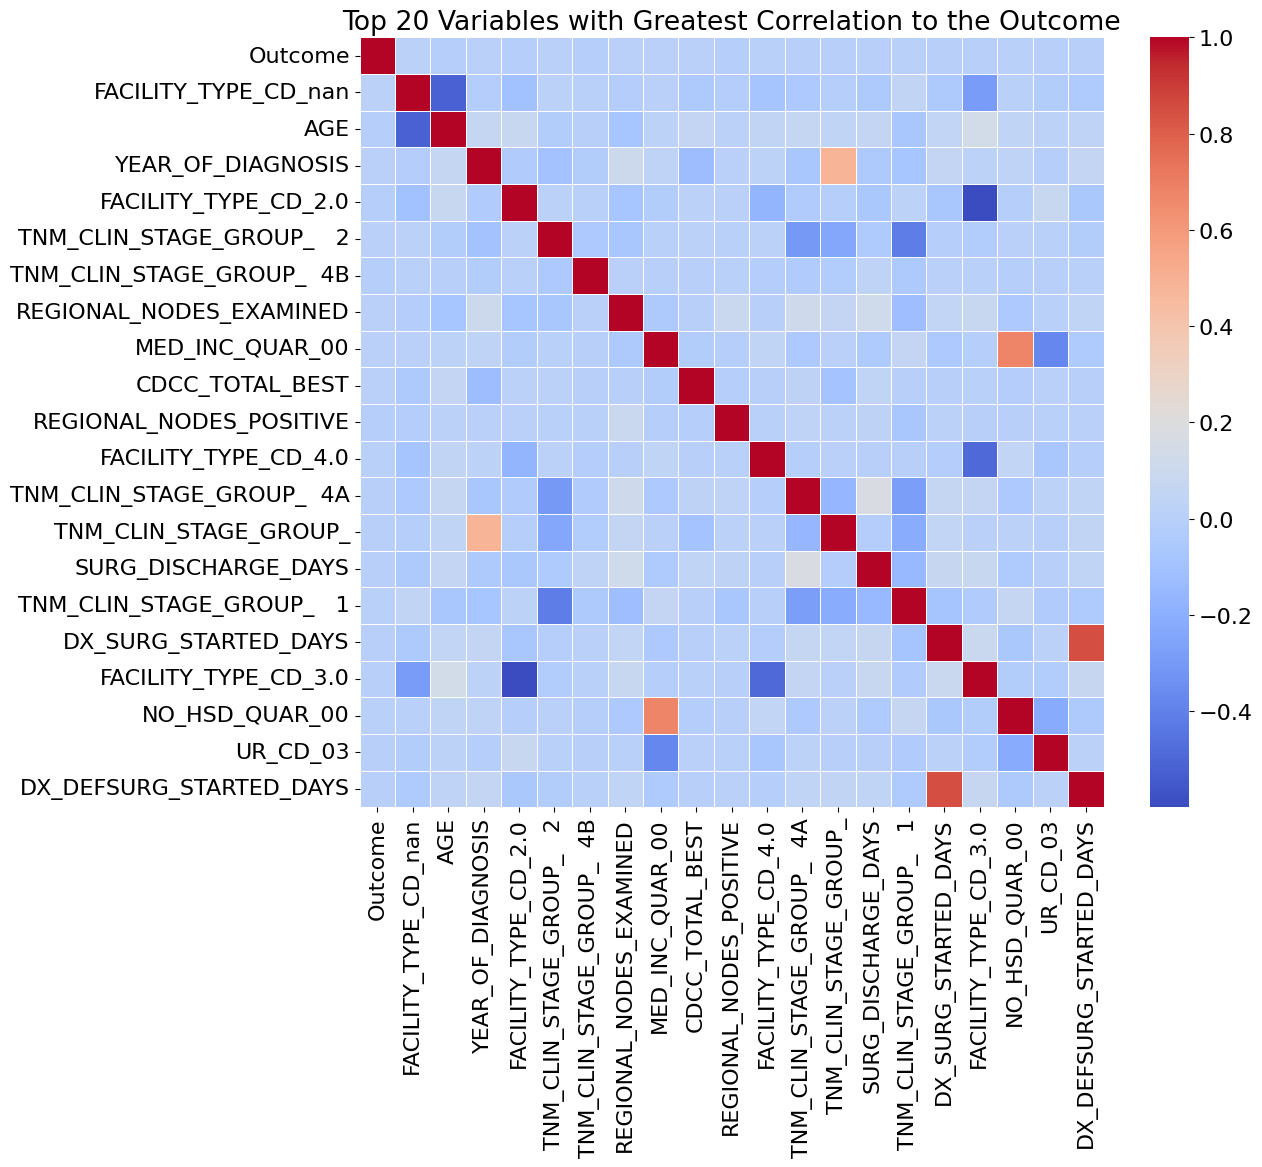

In [16]:
# Plot the covariance heatmap after feature reduction (or after preprocessing if feature reduction was not performed)
plot_covariance_heatmap(X_train, y_train, top_n=20)

In [17]:
# Optionally use PCA to transform the data features into principal component space
if use_PCA:
    X_train,X_test = pca_transform(X_train,X_test)

# Use SMOTE to resample the training data to make it more balanced
X_train,y_train = SMOTE_resample(X_train, X_test, y_train, y_test, sampling_strategy=0.5)

print('Data processing complete')
print('X_train shape: ',X_train.shape); print('X_test shape: ',X_test.shape); print('y_train shape: ',y_train.shape); print('y_test shape: ',y_test.shape)

# Save the variables to a file
with open(f'data/{experiment_name}_data_variables.pkl', 'wb') as f:
    pickle.dump((X_train, X_test, y_train, y_test), f)

print('Final columns')
print(X_train.columns.tolist())



There are 284.0 or 1% positive examples of out 32764 samples in the training data.
There are 71.0 or 1% positive examples of out 8191 samples in the test data.


After SMOTE there are 16240.0 or 33% positive examples in the training data out of 48720 samples in the training data.
Data processing complete
X_train shape:  (48720, 40)
X_test shape:  (8191, 40)
y_train shape:  (48720,)
y_test shape:  (8191,)
Final columns
['AGE', 'CROWFLY', 'YEAR_OF_DIAGNOSIS', 'REGIONAL_NODES_POSITIVE', 'TUMOR_SIZE_SUMMARY_16', 'TUMOR_SIZE', 'DX_SURG_STARTED_DAYS', 'DX_DEFSURG_STARTED_DAYS', 'SURG_DISCHARGE_DAYS', 'REGIONAL_NODES_EXAMINED', 'NO_HSD_QUAR_00', 'NO_HSD_QUAR_12', 'NO_HSD_QUAR_2016', 'MED_INC_QUAR_00', 'MED_INC_QUAR_12', 'MED_INC_QUAR_2016', 'UR_CD_03', 'UR_CD_13', 'CDCC_TOTAL_BEST', 'BEHAVIOR', 'RACE_1.0', 'RACE_2.0', 'SEX_1.0', 'SEX_2.0', 'FACILITY_TYPE_CD_1.0', 'FACILITY_TYPE_CD_2.0', 'FACILITY_TYPE_CD_3.0', 'FACILITY_TYPE_CD_4.0', 'FACILITY_TYPE_CD_nan', 'TNM_CLIN_STAGE_GROUP_', 'TNM_CLI

In [18]:
'''
Select 5 algorithms which can take normalized continuous variables and one-hot encoded categorical variables and output a probability
    1. XGBoost (Extreme Gradient Boosting)
    2. SGD Logistic Regression
    3. Logistic Regression
    4. CatBoost
    5. SVC
    (6.) LightGBM - too much memory requirement
    (7.) Neural Networks - too computationally expensive
    (8.) Gradient Boosting Classifier (e.g., scikit-learn's GradientBoostingClassifier) - too computationally expensive
Bootstrapped nested k-fold cross-validation (100-fold bootstrap, k=5, score should be the ROC-AUC score)
For the nested part, select a random range of hyperparameters appropriate for each of the 5 algorithms, with 20 different hyperparameter combinations total per algorithm
Plot progress bars showing training progress
Meh - Plot one bar plot per algorithm of ROC-AUC vs training param combination (thus the x-axis should have 20 ticks)
Print out the best hyperparameter combinations for each algorithm
Use stacking to get a single aggregate score based on all the 5 models with the best hyperparameter scores
Display Results
    Plot ROC-AUC plot showing the best bootstrapped nested k-fold cross-validation (ROC-AUC) score of each of the 5 algorithms + the 1 stacking algorithm score
    Plot bar plot showing the best bootstrapped nested k-fold cross-validation (ROC-AUC) score of each of the 5 algorithms + the 1 stacking algorithm score with error bars giving the 95% CI from bootstrapping
    Convert label probability into binary label (>=0.5 = 1, <0.5 = 0)
    Use binary labels to get accuracy, sensitivity, specificity, F1-score, and plot confusion matrix
Retrain the 5 models (with best hyperparams) and stacked model on the full train dataset (with progress bar)
Save the final trained 5 models and stacked model
    '''
# # Load the variables back from the file
# with open(f'{experiment_name}_data_variables.pkl', 'rb') as f:
#     X_train, X_test, y_train, y_test = pickle.load(f)

X_small = X_train[:500] # small version for testing
y_small = y_train[:500].ravel() # small version for testing

# Dictionary to collect all_models from each iteration
all_models = {}

# Iterate over each sub-dictionary in models_hyperparams
for model_name, model_hyperparams in models_hyperparams.items():
    save_filename = f'models/{experiment_name}_{model_name}_results_and_cv_model.pkl'
    
    # Check if this model's combined file already exists, if so, load it
    try:
        with open(save_filename, 'rb') as file:
            combined_data = pickle.load(file)
        results = combined_data["results"]
        model = combined_data["model"]
        print(f"Loaded saved combined file for {model_name}")
    except:
        # If not found, process, save, and combine this model and results
        if use_mini_dataset:
            results, model = process_and_save_combined(model_name, model_hyperparams, X_small, y_small, n_bootstraps_for_training, num_k_fold_splits, experiment_name)
        else:
            results, model = process_and_save_combined(model_name, model_hyperparams, X_train, y_train, n_bootstraps_for_training, num_k_fold_splits, experiment_name)
        print(f"Processed, saved, and combined for {model_name}")
    
    # Collect this model
    all_models.update(model)


Training XGBoost:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Best parameters for XGBoost: {'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.1}
Processed, saved, and combined for XGBoost


Training CatBoost:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Best parameters for CatBoost: {'iterations': 200, 'depth': 5, 'learning_rate': 0.1}
Processed, saved, and combined for CatBoost


Training Logistic Regression:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Best parameters for Logistic Regression: {'C': 100, 'penalty': 'l2'}
Processed, saved, and combined for Logistic Regression


Training SGD Logistic Regression:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Best parameters for SGD Logistic Regression: {'penalty': 'elasticnet'}
Processed, saved, and combined for SGD Logistic Regression


Training Gradient Boosting:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Best parameters for Gradient Boosting: {'n_estimators': 200, 'learning_rate': 0.1, 'max_depth': 5}
Processed, saved, and combined for Gradient Boosting


In [19]:
# Create a stacked model which incorporates all models
stacked_model = stack_models(all_models)
trained_stacked_model = None
trained_all_models = None

# Check if this model's combined file already exists, if so, load it
save_filename = f'models/{experiment_name}_trained_stacked_model.pkl'
try:
    # Load stacked_model
    with open(f'/models/{experiment_name}_trained_stacked_model.pkl', 'rb') as file:
        trained_stacked_model = pickle.load(file)

    # Load all_models
    with open(f'/models/{experiment_name}_trained_all_models.pkl', 'rb') as file:
        trained_all_models = pickle.load(file)
    print(f"Loaded saved trained models for {experiment_name}")
except:
    print('Retraining all models plus stacked model on the full training dataset...')
    if use_mini_dataset:
        trained_stacked_model, trained_all_models = retrain_models(stacked_model, all_models, 
                                                               X_small, y_small)
    else:
        trained_stacked_model, trained_all_models = retrain_models(stacked_model, all_models, 
                                                               X_train, y_train)

    # Save stacked_model
    with open(f'models/{experiment_name}_trained_stacked_model.pkl', 'wb') as file:
        pickle.dump(trained_stacked_model, file)
    # Save all_models
    with open(f'models/{experiment_name}_trained_all_models.pkl', 'wb') as file:
        pickle.dump(trained_all_models, file)


Retraining all models plus stacked model on the full training dataset...


In [20]:
# # # Load the variables back from the file
# # with open('/data/data_variables.pkl', 'rb') as f:
# #     X_train, X_test, y_train, y_test = pickle.load(f)

# # # Load stacked_model
# # with open('/models/trained_stacked_model.pkl', 'rb') as file:
# #     trained_stacked_model = pickle.load(file)

# # # Load all_models
# # with open('/models/trained_all_models.pkl', 'rb') as file:
# #     trained_all_models = pickle.load(file)

# print('Training performance results')
# display_results(trained_stacked_model, trained_all_models, X_train, y_train, class_labels, target_fpr=0.5, plot_ci=False, n_bootstraps = n_bootstraps_for_results)

# print('Testing performance results')
# display_results(trained_stacked_model, trained_all_models, X_test, y_test, class_labels, target_fpr=0.5, plot_ci=False, n_bootstraps = n_bootstraps_for_results)

In [21]:
# Further split the held out test set into validation and final test sets
# Overall split should be 80% train, 10% val, 10% test

X_val, X_test, y_val, y_test = tts(
    X_test, y_test,
    test_size=1/2,   # ensures 10% val, 21% test overall
    stratify=y_test,
    random_state=42
)

print(f'Final dataset sizes: X_train: {X_train.shape}, y_train: {y_train.shape}, '
      f'X_val: {X_val.shape}, y_val: {y_val.shape}, '
      f'X_test: {X_test.shape}, y_test: {y_test.shape}')

print(f'Final label distributions: '
      f'y_train: {np.mean(y_train)*100:.2f}% positive, '
      f'y_val: {np.mean(y_val)*100:.2f}% positive, '
      f'y_test: {np.mean(y_test)*100:.2f}% positive')

Final dataset sizes: X_train: (48720, 40), y_train: (48720,), X_val: (4095, 40), y_val: (4095,), X_test: (4096, 40), y_test: (4096,)
Final label distributions: y_train: 33.33% positive, y_val: 0.85% positive, y_test: 0.88% positive


In [22]:
# Write a function that takes trained_stacked_model, trained_all_models, X_val, y_val, and any other necessary parameters and calibrates the models using Isotonic Regression or Platt Scaling

trained_stacked_model, trained_all_models = calibrate_models(trained_stacked_model, trained_all_models, X_val, y_val, method='auto')

import cloudpickle # cloudpickle better than pickle for cross-version compatibility

with open(f'models/{experiment_name}_calibrated_trained_stacked_model.pkl', "wb") as f:
    cloudpickle.dump(trained_stacked_model, f)

with open(f'models/{experiment_name}_calibrated_trained_all_models.pkl', "wb") as f:
    cloudpickle.dump(trained_all_models, f)

/Users/danfu/miniconda3/envs/aman_demo/lib/python3.12/site-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/Users/danfu/miniconda3/envs/aman_demo/lib/python3.12/site-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/Users/danfu/miniconda3/envs/aman_demo/lib/python3.12/site-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/Users/danfu/miniconda3/envs/aman_demo/lib/python3.12/site-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. Y

Training performance results


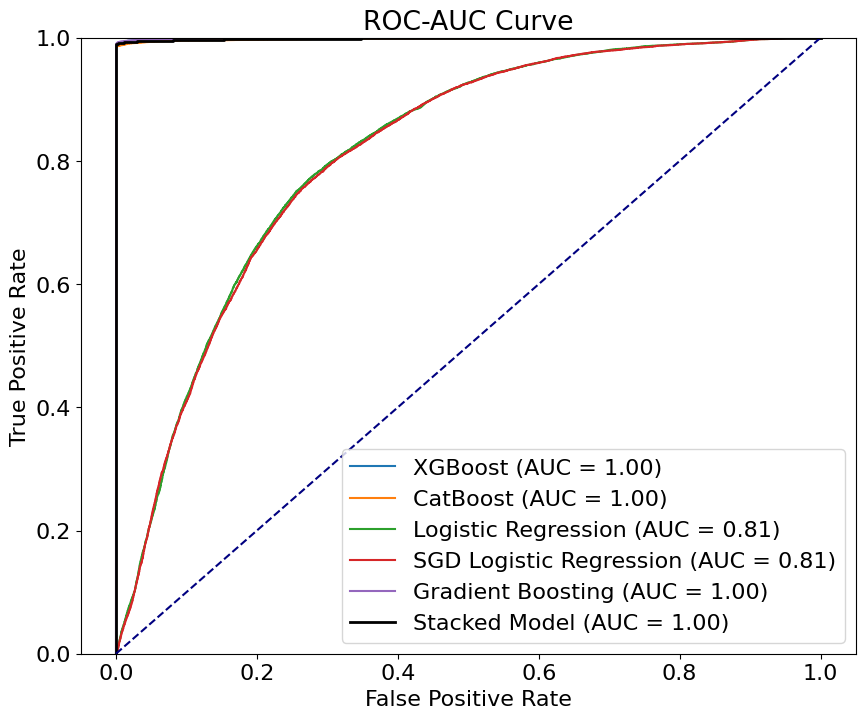

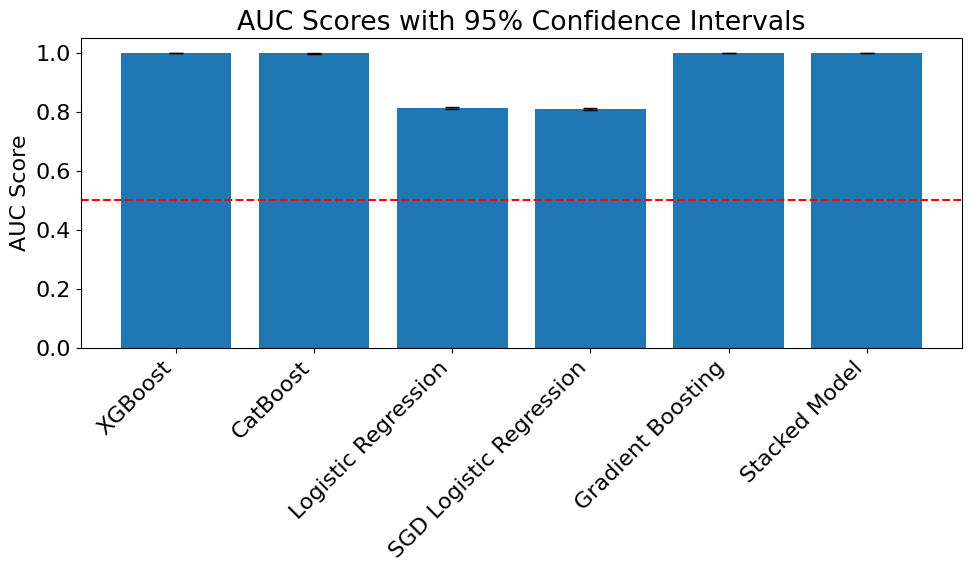

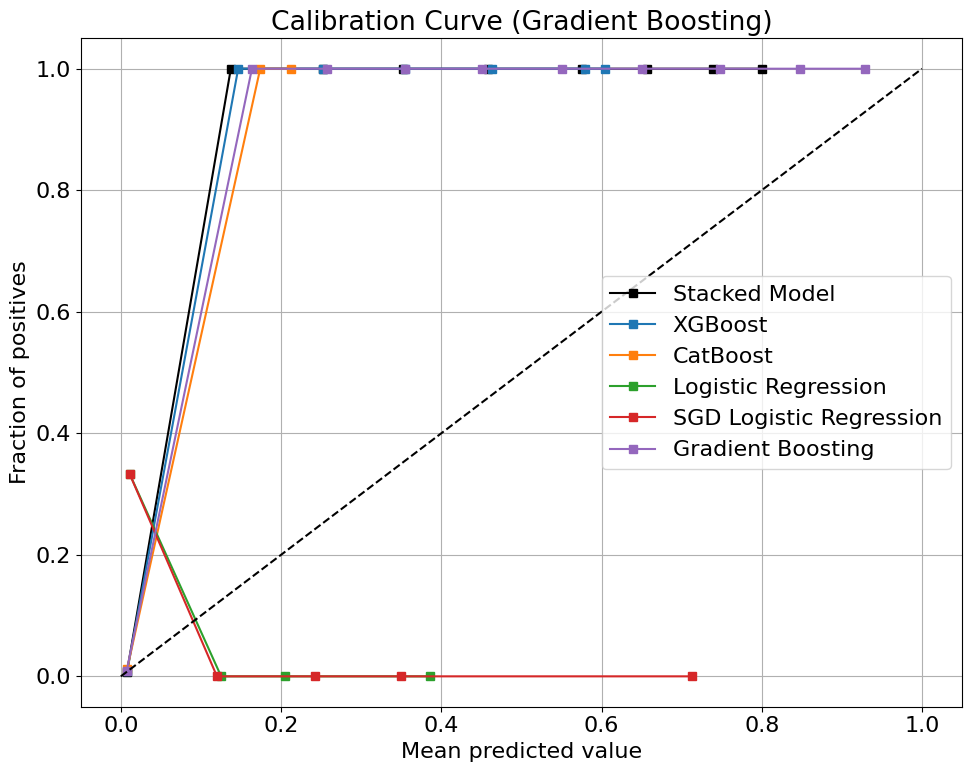

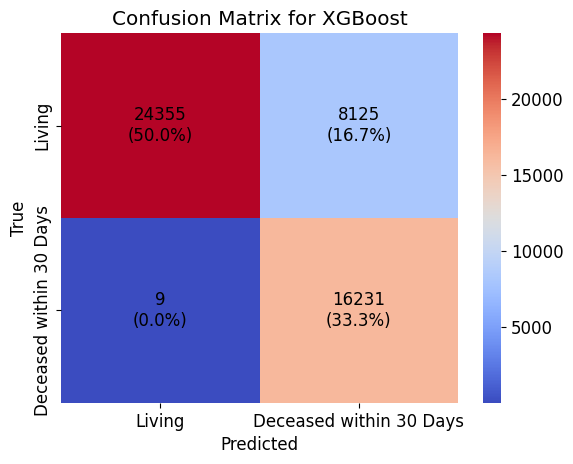


XGBoost:
AUC: 1.00 (95% CI: 1.00-1.00)
Accuracy: 0.83 (95% CI: 0.83-0.84)
Sensitivity: 1.00 (95% CI: 1.00-1.00)
Specificity: 0.75 (95% CI: 0.74-0.75)
F1-Score: 0.80 (95% CI: 0.80-0.80)
Relative Risk: 1804.04 (95% CI: 1078.00-5373.89)
Absolute Risk High: 0.6664 (95% CI: 0.6602-0.6707)
Absolute Risk Low: 0.0004 (95% CI: 0.0001-0.0006)
Attributable Risk: 0.6660 (95% CI: 0.6597-0.6704)
P-value for group comparison: 0.000000000


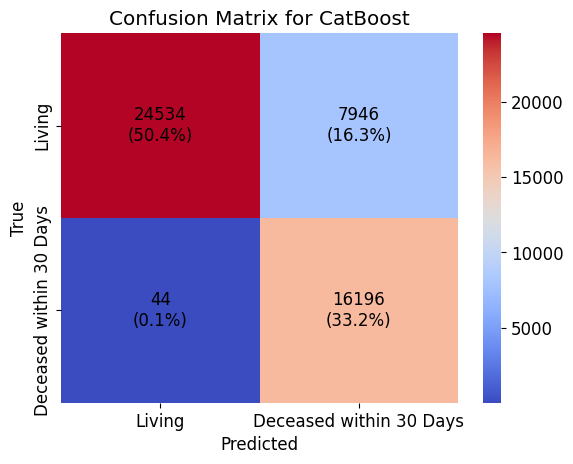


CatBoost:
AUC: 1.00 (95% CI: 1.00-1.00)
Accuracy: 0.84 (95% CI: 0.83-0.84)
Sensitivity: 1.00 (95% CI: 1.00-1.00)
Specificity: 0.76 (95% CI: 0.75-0.76)
F1-Score: 0.80 (95% CI: 0.80-0.81)
Relative Risk: 374.74 (95% CI: 274.21-507.44)
Absolute Risk High: 0.6709 (95% CI: 0.6652-0.6757)
Absolute Risk Low: 0.0018 (95% CI: 0.0013-0.0024)
Attributable Risk: 0.6691 (95% CI: 0.6631-0.6740)
P-value for group comparison: 0.000000000


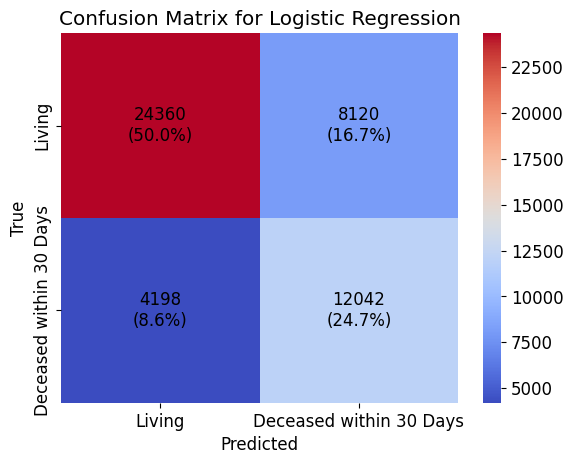


Logistic Regression:
AUC: 0.81 (95% CI: 0.81-0.82)
Accuracy: 0.75 (95% CI: 0.74-0.75)
Sensitivity: 0.74 (95% CI: 0.74-0.75)
Specificity: 0.75 (95% CI: 0.75-0.75)
F1-Score: 0.66 (95% CI: 0.66-0.67)
Relative Risk: 4.06 (95% CI: 3.93-4.20)
Absolute Risk High: 0.5973 (95% CI: 0.5903-0.6035)
Absolute Risk Low: 0.1470 (95% CI: 0.1423-0.1515)
Attributable Risk: 0.4503 (95% CI: 0.4434-0.4582)
P-value for group comparison: 0.000000000


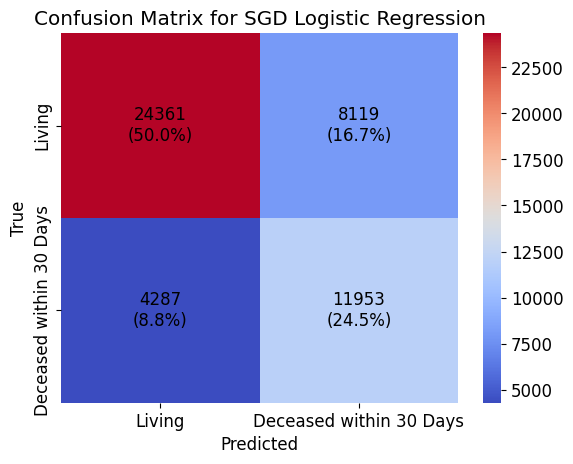


SGD Logistic Regression:
AUC: 0.81 (95% CI: 0.81-0.81)
Accuracy: 0.75 (95% CI: 0.74-0.75)
Sensitivity: 0.74 (95% CI: 0.73-0.74)
Specificity: 0.75 (95% CI: 0.75-0.75)
F1-Score: 0.66 (95% CI: 0.65-0.66)
Relative Risk: 3.98 (95% CI: 3.86-4.10)
Absolute Risk High: 0.5955 (95% CI: 0.5883-0.6013)
Absolute Risk Low: 0.1496 (95% CI: 0.1456-0.1542)
Attributable Risk: 0.4459 (95% CI: 0.4380-0.4525)
P-value for group comparison: 0.000000000


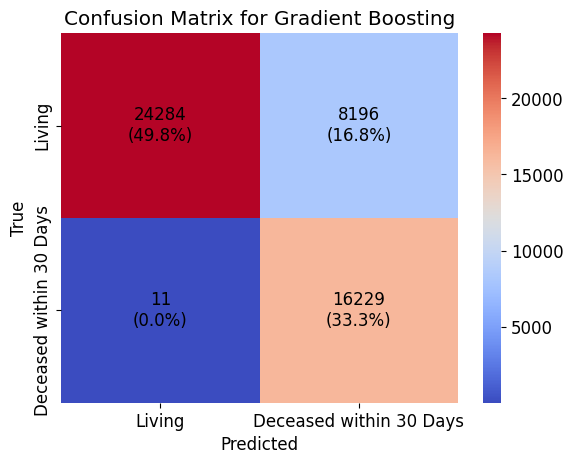


Gradient Boosting:
AUC: 1.00 (95% CI: 1.00-1.00)
Accuracy: 0.83 (95% CI: 0.83-0.83)
Sensitivity: 1.00 (95% CI: 1.00-1.00)
Specificity: 0.75 (95% CI: 0.74-0.75)
F1-Score: 0.80 (95% CI: 0.79-0.80)
Relative Risk: 1467.51 (95% CI: 865.79-3228.85)
Absolute Risk High: 0.6644 (95% CI: 0.6583-0.6697)
Absolute Risk Low: 0.0005 (95% CI: 0.0002-0.0008)
Attributable Risk: 0.6640 (95% CI: 0.6575-0.6693)
P-value for group comparison: 0.000000000


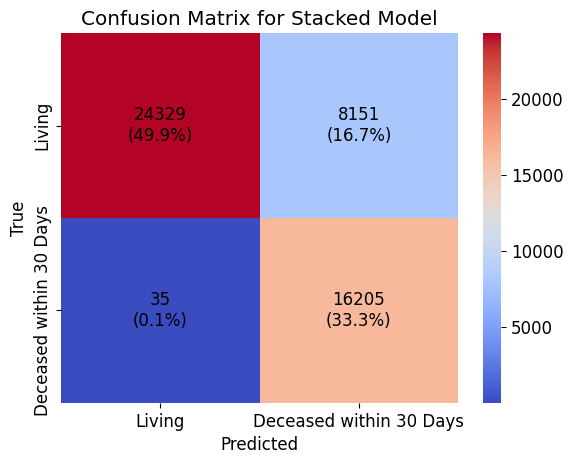


Stacked Model:
AUC: 1.00 (95% CI: 1.00-1.00)
Accuracy: 0.83 (95% CI: 0.83-0.83)
Sensitivity: 1.00 (95% CI: 1.00-1.00)
Specificity: 0.75 (95% CI: 0.75-0.75)
F1-Score: 0.80 (95% CI: 0.79-0.80)
Relative Risk: 463.15 (95% CI: 341.82-646.98)
Absolute Risk High: 0.6653 (95% CI: 0.6598-0.6701)
Absolute Risk Low: 0.0014 (95% CI: 0.0010-0.0019)
Attributable Risk: 0.6639 (95% CI: 0.6582-0.6684)
P-value for group comparison: 0.000000000
Testing performance results


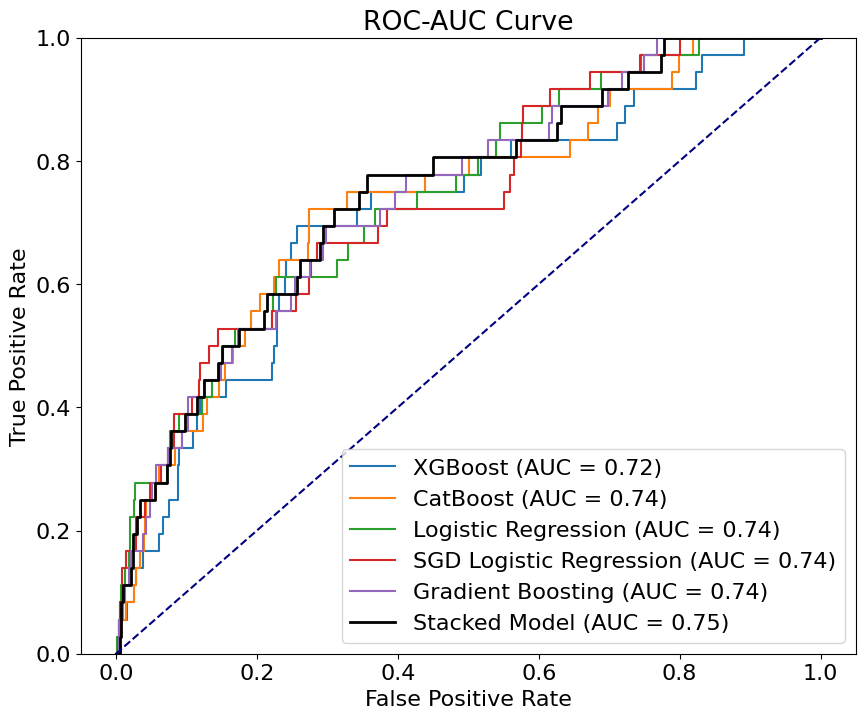

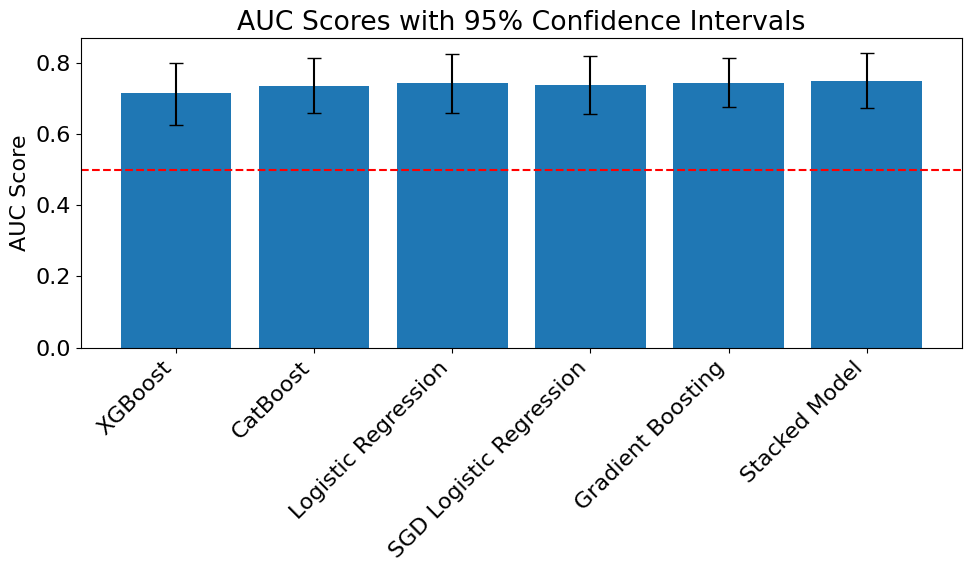

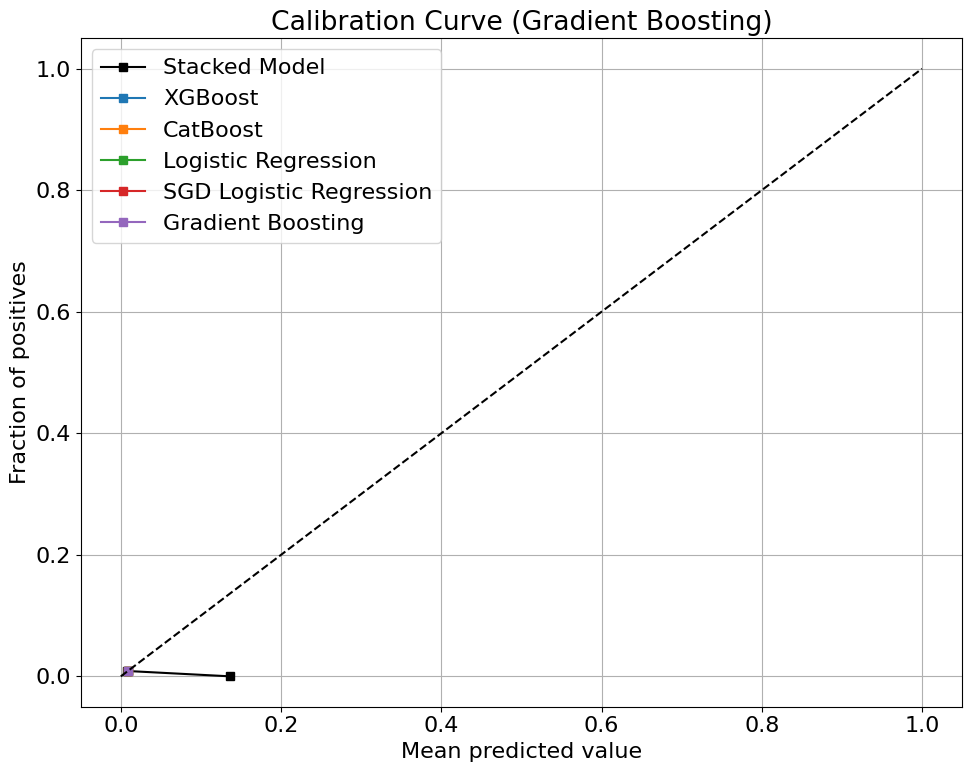

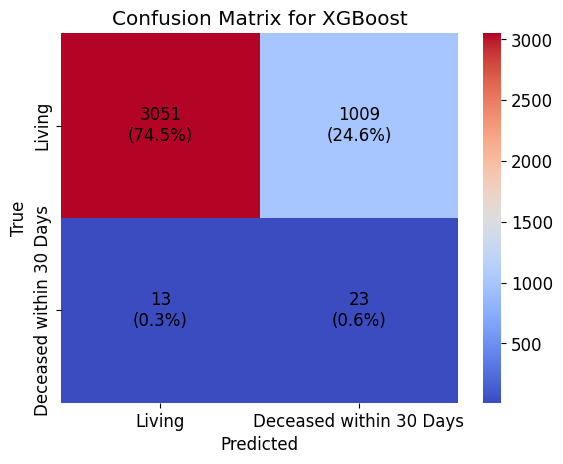


XGBoost:
AUC: 0.72 (95% CI: 0.63-0.80)
Accuracy: 0.75 (95% CI: 0.74-0.76)
Sensitivity: 0.65 (95% CI: 0.50-0.78)
Specificity: 0.75 (95% CI: 0.74-0.77)
F1-Score: 0.04 (95% CI: 0.03-0.06)
Relative Risk: 5.25 (95% CI: 3.02-10.83)
Absolute Risk High: 0.0223 (95% CI: 0.0157-0.0301)
Absolute Risk Low: 0.0042 (95% CI: 0.0021-0.0062)
Attributable Risk: 0.0180 (95% CI: 0.0111-0.0267)
P-value for group comparison: 0.000000224


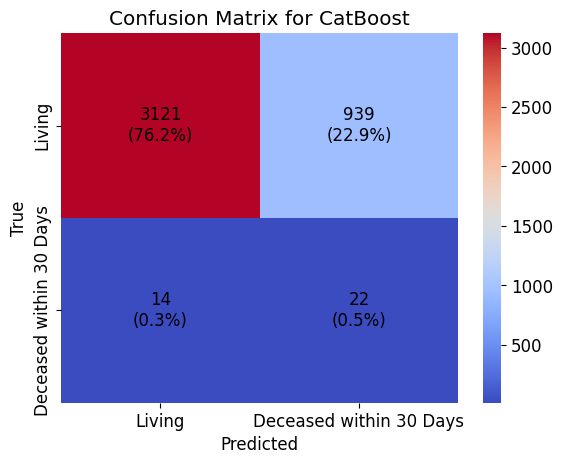


CatBoost:
AUC: 0.74 (95% CI: 0.66-0.82)
Accuracy: 0.77 (95% CI: 0.76-0.78)
Sensitivity: 0.62 (95% CI: 0.43-0.76)
Specificity: 0.77 (95% CI: 0.76-0.78)
F1-Score: 0.04 (95% CI: 0.03-0.06)
Relative Risk: 5.13 (95% CI: 2.43-10.08)
Absolute Risk High: 0.0229 (95% CI: 0.0137-0.0309)
Absolute Risk Low: 0.0045 (95% CI: 0.0021-0.0064)
Attributable Risk: 0.0184 (95% CI: 0.0085-0.0276)
P-value for group comparison: 0.000000251


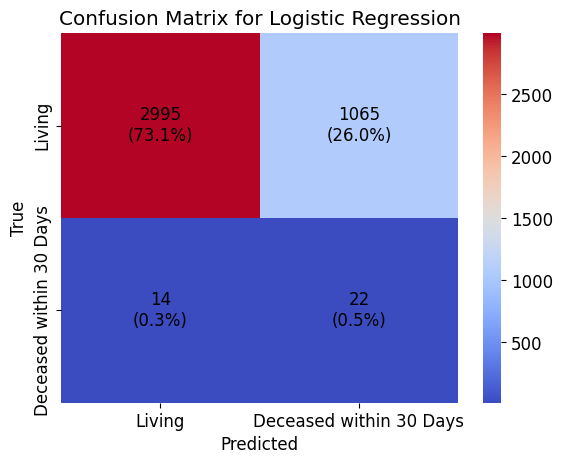


Logistic Regression:
AUC: 0.75 (95% CI: 0.66-0.83)
Accuracy: 0.74 (95% CI: 0.72-0.75)
Sensitivity: 0.62 (95% CI: 0.47-0.77)
Specificity: 0.74 (95% CI: 0.73-0.75)
F1-Score: 0.04 (95% CI: 0.02-0.05)
Relative Risk: 4.35 (95% CI: 2.45-9.68)
Absolute Risk High: 0.0202 (95% CI: 0.0126-0.0280)
Absolute Risk Low: 0.0047 (95% CI: 0.0020-0.0066)
Attributable Risk: 0.0156 (95% CI: 0.0077-0.0239)
P-value for group comparison: 0.000005917


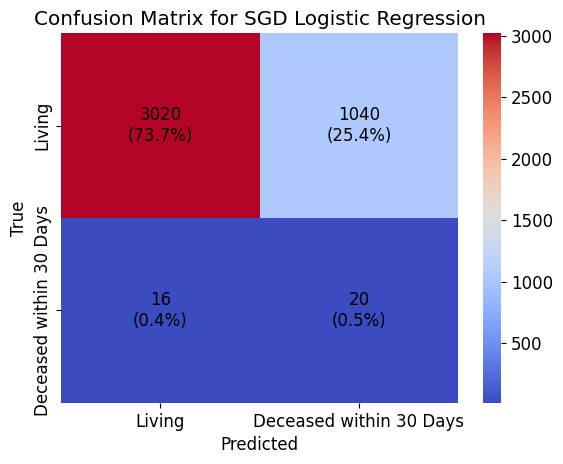


SGD Logistic Regression:
AUC: 0.75 (95% CI: 0.66-0.82)
Accuracy: 0.74 (95% CI: 0.73-0.76)
Sensitivity: 0.57 (95% CI: 0.41-0.73)
Specificity: 0.74 (95% CI: 0.73-0.76)
F1-Score: 0.04 (95% CI: 0.02-0.05)
Relative Risk: 3.58 (95% CI: 1.94-7.45)
Absolute Risk High: 0.0189 (95% CI: 0.0117-0.0267)
Absolute Risk Low: 0.0053 (95% CI: 0.0025-0.0072)
Attributable Risk: 0.0136 (95% CI: 0.0062-0.0221)
P-value for group comparison: 0.000099237


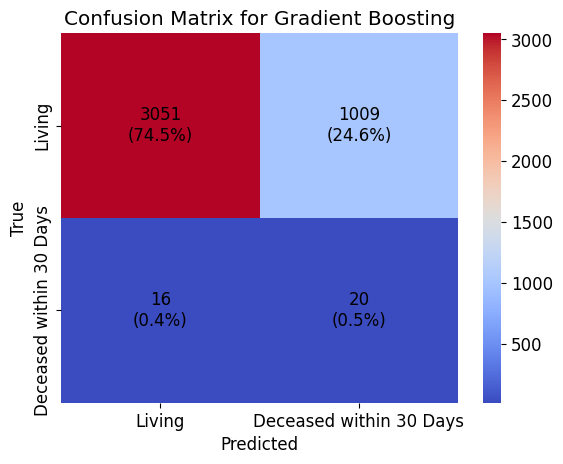


Gradient Boosting:
AUC: 0.75 (95% CI: 0.68-0.81)
Accuracy: 0.75 (95% CI: 0.74-0.76)
Sensitivity: 0.56 (95% CI: 0.42-0.71)
Specificity: 0.75 (95% CI: 0.74-0.76)
F1-Score: 0.04 (95% CI: 0.02-0.05)
Relative Risk: 3.73 (95% CI: 2.14-7.26)
Absolute Risk High: 0.0194 (95% CI: 0.0126-0.0258)
Absolute Risk Low: 0.0052 (95% CI: 0.0029-0.0070)
Attributable Risk: 0.0142 (95% CI: 0.0071-0.0209)
P-value for group comparison: 0.000054418


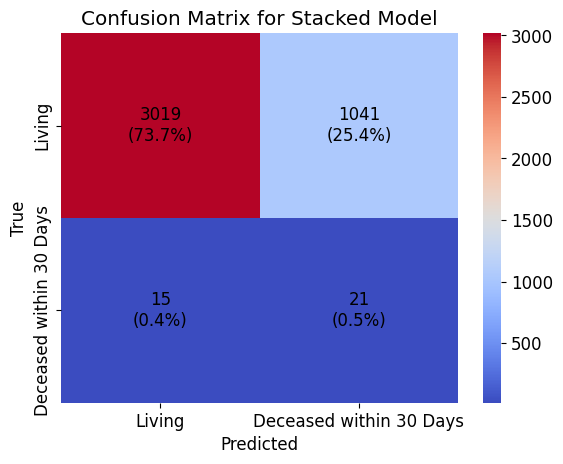


Stacked Model:
AUC: 0.75 (95% CI: 0.67-0.83)
Accuracy: 0.74 (95% CI: 0.73-0.76)
Sensitivity: 0.60 (95% CI: 0.47-0.76)
Specificity: 0.74 (95% CI: 0.73-0.76)
F1-Score: 0.04 (95% CI: 0.03-0.05)
Relative Risk: 4.00 (95% CI: 2.46-8.71)
Absolute Risk High: 0.0198 (95% CI: 0.0130-0.0277)
Absolute Risk Low: 0.0049 (95% CI: 0.0020-0.0066)
Attributable Risk: 0.0148 (95% CI: 0.0080-0.0233)
P-value for group comparison: 0.000019960


In [23]:
# Target FPR 0.25

print('Training performance results')
display_results(trained_stacked_model, trained_all_models, X_train, y_train, class_labels, target_fpr=0.25, plot_ci=False, n_bootstraps = n_bootstraps_for_results)

print('Testing performance results')
display_results(trained_stacked_model, trained_all_models, X_test, y_test, class_labels, target_fpr=0.25, plot_ci=False, n_bootstraps = n_bootstraps_for_results)

In [24]:
def subgroup_analysis(subgroup_column, variable_type, trained_stacked_model, trained_all_models, X_test, y_test):
    if not isinstance(X_test, pd.DataFrame):
        raise ValueError("X_test must be a pandas DataFrame.")

    # Initializing variables to store results
    subgroups = []
    model_names = ['Stacked Model'] + list(trained_all_models.keys())
    auc_scores_dict = {model_name: [] for model_name in model_names}
    
    def compute_auc_scores(subgroup_indices):
        for model_name in auc_scores_dict.keys():
            if model_name == 'Stacked Model':
                model = trained_stacked_model
            else:
                model = trained_all_models[model_name]
            auc_score = roc_auc_score(y_test[subgroup_indices], model.predict_proba(X_test.iloc[subgroup_indices])[:, 1])
            auc_scores_dict[model_name].append(auc_score)
    
    if variable_type == 'continuous':
        split_value = 0  # Assuming normalization to mean=0
        
        # Splitting the data into subgroups
        index_below = np.where(X_test[subgroup_column] <= split_value)[0]
        index_above = np.where(X_test[subgroup_column] > split_value)[0]

        # Compute AUC for each subgroup
        compute_auc_scores(index_below)
        compute_auc_scores(index_above)
        
        subgroups = ['Below or Equal Mean', 'Above Mean']

    elif variable_type == 'categorical':
        categories = [col.split('_')[-1] for col in X_test.columns if subgroup_column in col]
        others_auc_scores = {model_name: [] for model_name in model_names}
        
        for category in categories:
            column_name = f"{subgroup_column}_{category}"
            if column_name in X_test.columns:
                index_cat = np.where(X_test[column_name] == 1)[0]

                # Compute AUC for the subgroup or add to "Other"
                if len(index_cat) / len(X_test) < 0.01:
                    for model_name in others_auc_scores.keys():
                        others_auc_scores[model_name].append(roc_auc_score(y_test[index_cat], trained_all_models[model_name].predict_proba(X_test.iloc[index_cat])[:, 1] if model_name != 'Stacked Model' else trained_stacked_model.predict_proba(X_test.iloc[index_cat])[:, 1]))
                else:
                    compute_auc_scores(index_cat)
                    subgroups.append(category)

        # Handle "Other" category
        if any(others_auc_scores[model_name] for model_name in model_names):
            subgroups.append("Other")
            for model_name, scores in others_auc_scores.items():
                auc_scores_dict[model_name].append(np.mean(scores))

    else:
        raise ValueError("variable_type must be either 'continuous' or 'categorical'.")

    # Plotting
    fig, ax = plt.subplots(figsize=(10, 6))
    width = 0.1  # Width of each bar
    x = np.arange(len(subgroups))
    
    for i, model_name in enumerate(model_names):
        if model_name == 'Stacked Model':
            ax.bar(x - 0.2 + i*width, auc_scores_dict[model_name], width, color='black', label=model_name)
        else:
            ax.bar(x - 0.2 + i*width, auc_scores_dict[model_name], width, label=model_name)
    
    ax.set_xlabel('Subgroup')
    ax.set_ylabel('AUC')
    ax.set_title(f'AUC by Subgroup for {subgroup_column}')
    ax.set_xticks(x)
    ax.set_xticklabels(subgroups, rotation=45)
#     ax.legend()
    ax.legend(loc='lower center', fontsize='small')

    
    plt.tight_layout()
    plt.ylim([0,1.0])
    plt.show()

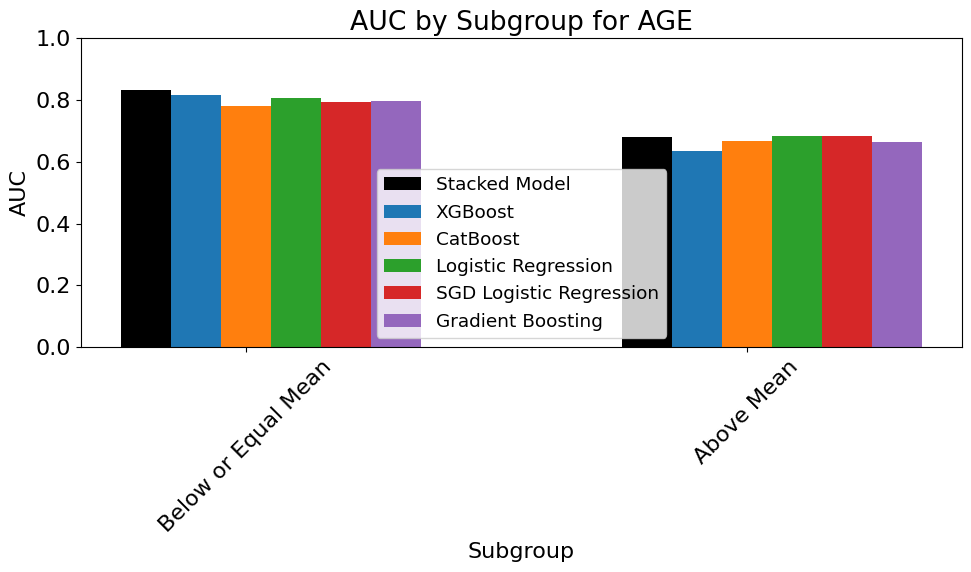

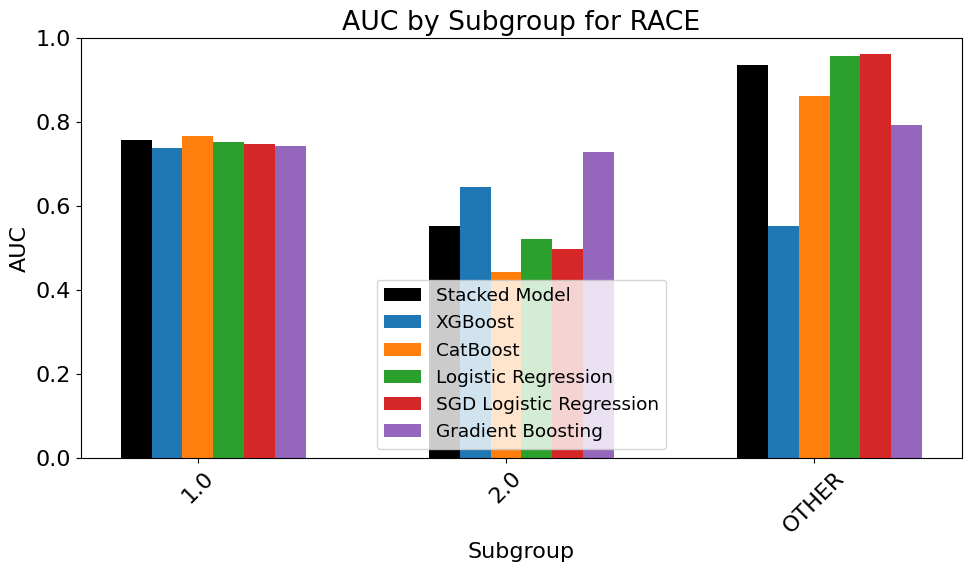

In [25]:
# For continuous variable AGE
subgroup_analysis('AGE', 'continuous', trained_stacked_model,trained_all_models, X_test, y_test)

# For categorical variable RACE
subgroup_analysis('RACE', 'categorical', trained_stacked_model,trained_all_models, X_test, y_test)

In [26]:
race_columns = [col for col in X_test.columns if "RACE_" in col]
print(race_columns)

['RACE_1.0', 'RACE_2.0', 'RACE_OTHER']


PermutationExplainer explainer: 4097it [15:23,  4.40it/s]                          
/Users/danfu/Research/Rutgers_Research/AmanResearch/ONM Outcomes/ent_utils.py:1849: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.


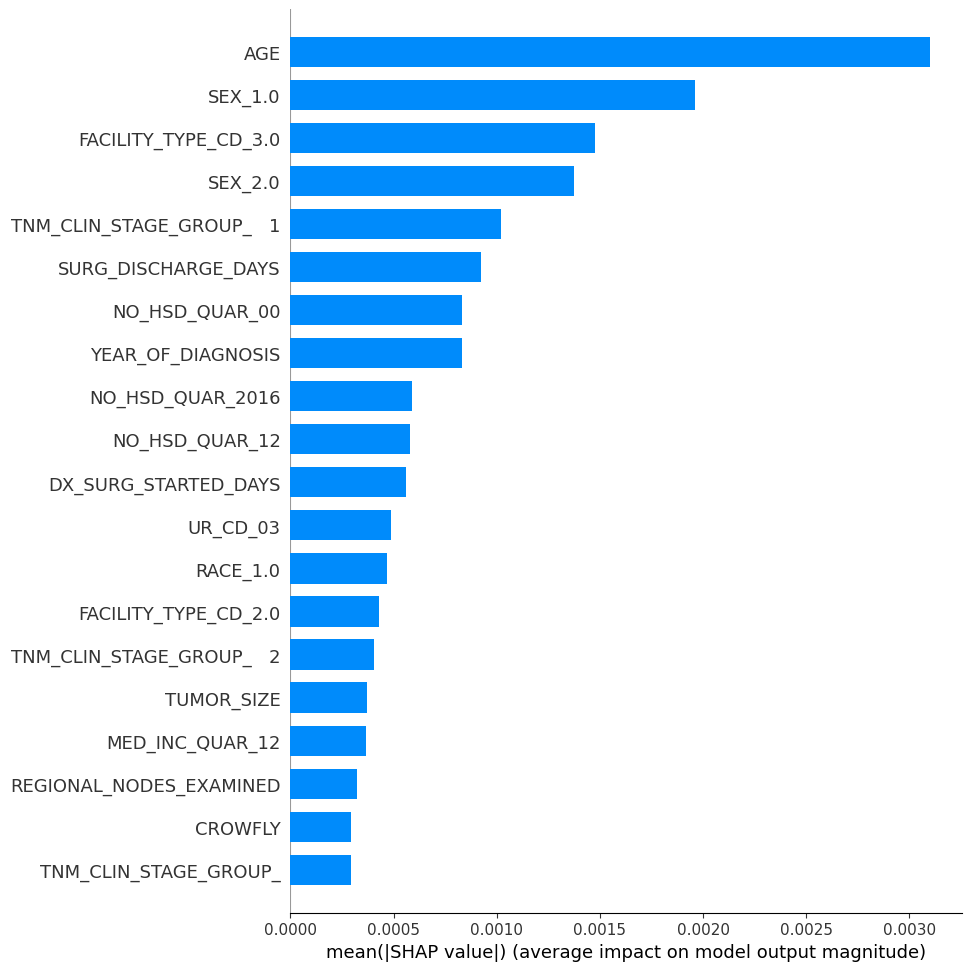

In [27]:
save_filename = f'models/{experiment_name}_trained_stacked_model_shap.pkl'

if use_mini_dataset: 
    explainer, shap_values = model_interpretability(trained_stacked_model, X_small, y_small, save_filename)
else:
    explainer, shap_values = model_interpretability(trained_stacked_model, X_test, y_test, save_filename)

In [28]:
# Record the end time
end_time = datetime.datetime.now()

# Calculate the total runtime
total_runtime = end_time - start_time

# Convert total runtime to a format of days, hours, minutes, and seconds
formatted_runtime = str(total_runtime).split('.')[0]  # Remove microseconds

print(f"Total runtime: {formatted_runtime}")

Total runtime: 2:02:24
